In [298]:
import os
import glob
import shutil 
import numpy as np 
import pandas as pd
from pathlib import Path

## Get Data

In [299]:
cluster_dir = Path('/Users/carlydrzewiecki/Desktop/trainor_cluster')

In [300]:
sample_data = pd.read_csv(cluster_dir/'7170_INT, dlc.csv', header=None)

## Clean data

In [301]:
### sweep sweep sweep, data clean up

### Rename the columns based on the multi-index set up

for i in range(1, len(sample_data.columns)):
    j = sample_data.iloc[1:4, i:i+1].values
    col_name = str(j[0])+'_'+str(j[1])+'_'+str(j[2])
    col_name = col_name.replace('[', '').replace(']', '').replace("'", '')
    sample_data.rename(columns={i:col_name}, inplace=True)

#Reformat the sample data, remove the multi-index rows
sample_data = sample_data.iloc[4:, :]
sample_data.rename(columns={0:'frame'}, inplace=True)

#Convert the data to floats
sample_data = sample_data.astype(float)

#Replace all instances of individual1 in column names with test_subject
sample_data.columns = sample_data.columns.str.replace('individual1', 'testsubject')
sample_data.columns = sample_data.columns.str.replace('individual2', 'intruder')

#reset the index
sample_data = sample_data.reset_index(drop=True)


In [302]:
#sample_data

,frame,testsubject_nose_x,testsubject_nose_y,testsubject_nose_likelihood,testsubject_rightear_x,testsubject_rightear_y,testsubject_rightear_likelihood,testsubject_leftear_x,testsubject_leftear_y,testsubject_leftear_likelihood,...,intruder_rightleg_likelihood,intruder_leftleg_x,intruder_leftleg_y,intruder_leftleg_likelihood,intruder_tailbase_x,intruder_tailbase_y,intruder_tailbase_likelihood,intruder_tailtip_x,intruder_tailtip_y,intruder_tailtip_likelihood
0,0.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,6826.0,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,670.136,605.596,1.0,682.163,595.582,1.000,NaN,NaN,0.0
6827,6827.0,731.882,716.036,0.256,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,670.130,605.110,1.0,682.734,596.434,1.000,NaN,NaN,0.0
6828,6828.0,731.953,708.083,0.129,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,670.073,602.540,1.0,677.446,595.933,0.999,NaN,NaN,0.0
6829,6829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,671.823,607.375,1.0,683.034,597.787,1.000,NaN,NaN,0.0


In [303]:
col_names = sample_data.columns

body_parts = []

for i, data in enumerate(col_names):
    if i > 0:
        if data.split('_')[1] not in body_parts:
            body_parts.append(data.split('_')[1])

In [304]:
#body_parts

['nose',
 'rightear',
 'leftear',
 'midpoint',
 'rightleg',
 'leftleg',
 'tailbase',
 'tailtip']

## Calculate distances between dlc markers

In [305]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_distance_between_mice(df, sub1, body_part1, sub2, body_part2):
    return euclidean_distance(df[sub1+'_'+body_part1+'_x'], df[sub1+'_'+body_part1+'_y'], 
    df[sub2+'_'+body_part2+'_x'], df[sub2+'_'+body_part2+'_y'])



In [472]:
#between centroid distance (Falkner does this from top view)
dist_between_mice = get_distance_between_mice(sample_data, 'testsubject', 'midpoint', 'intruder', 'midpoint')

#distance between test subject rear and intruder nose
get_distance_between_mice(sample_data, 'testsubject', 'tailbase', 'intruder', 'nose')

#distance between test subject nose and intruder nose
get_distance_between_mice(sample_data, 'testsubject', 'nose', 'intruder', 'nose')

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
6826           NaN
6827    200.439930
6828    196.993567
6829           NaN
6830    201.345695
Length: 6831, dtype: float64

In [477]:
### Someone should double check my math here
### ALSO I am making the assumption that the edges of the video correspond to the edges of the arena

def get_distance_between_edge(df, sub1, body_part1, edge):
    if edge == 'left':
        return euclidean_distance(df[sub1+'_'+body_part1+'_x'], 0, 0, 0)
    elif edge == 'right':
        return euclidean_distance(df[sub1+'_'+body_part1+'_x'], 0, 1173, 0)
        ## 1173 is the width of the arena in pixels (51 cm long, each cm is 23 pixels)
    elif edge == 'bottom':
        return euclidean_distance(0, df[sub1+'_'+body_part1+'_y'], 0, 0)

In [388]:
dist_from_left_wall = get_distance_between_edge(sample_data, 'testsubject', 'nose', 'left')
dist_from_left_wall = get_distance_between_edge(sample_data, 'testsubject', 'nose', 'right')

#rearing
get_distance_between_edge(sample_data, 'testsubject', 'nose', 'bottom')
get_distance_between_edge(sample_data, 'intruder', 'nose', 'bottom')


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
6826        NaN
6827    273.960
6828    273.889
6829        NaN
6830    274.542
Name: testsubject_nose_x, Length: 6831, dtype: float64

<AxesSubplot:>

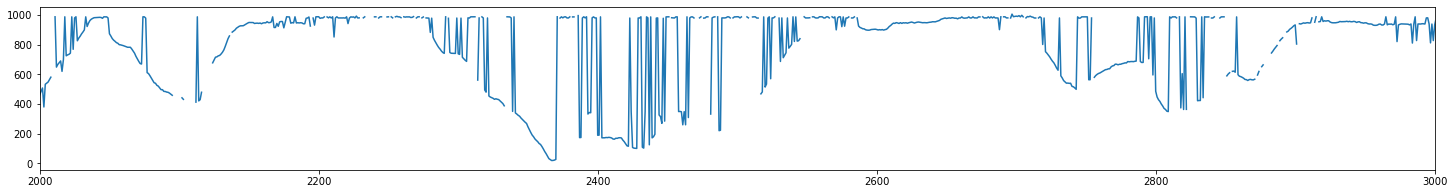

In [479]:
#dist_from_left_wall.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3))
dist_from_left_wall.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3), xlim = (2000, 3000))




<AxesSubplot:>

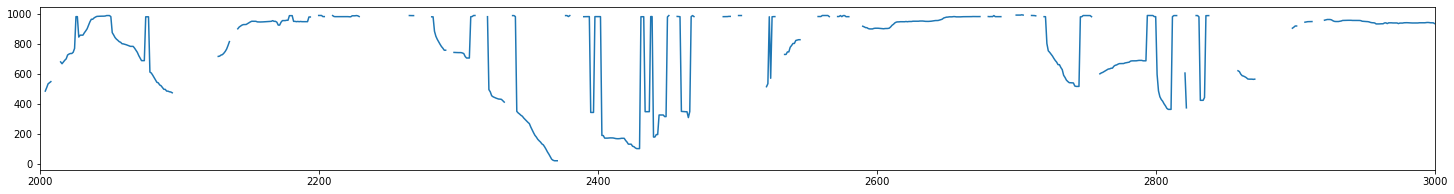

In [483]:
##Should we smooth all the distance data??
left_wall_dist_smoothed = dist_from_left_wall.rolling(5).median()
left_wall_dist_smoothed.plot.line(x = 'frame', y = 'dist_from_left_wall', figsize = (25, 3), xlim = (2000, 3000))



## Velocity

In [395]:
### I am not 100% sure this is correct so someone should double check this

def get_derivative(df, x, y):
    df['dx'] = df[x].diff()
    df['dy'] = df[y].diff()
    #slope = rise/run
    df['dist_traveled_by_frame'] = df['dy']/df['dx']
    return df

In [461]:
def smooth_data(df, window):
    df_smoothed = df.rolling(window).median()
    return df_smoothed

def get_velocity(df, sub1, body_part1):
    dist_list = []
    for i in range(len(df)-1):
        dist_traveled = euclidean_distance(df[sub1+'_'+body_part1+'_x'][i], df[sub1+'_'+body_part1+'_y'][i], df[sub1+'_'+body_part1+'_x'][i+1], df[sub1+'_'+body_part1+'_y'][i+1])
        dist_list.append(dist_traveled)
    dist_df = pd.DataFrame(dist_list)
    #median smooth
    distance_smoothed = smooth_data(dist_df, 3)
    #format this dataset so it makes sense....
    distance_smoothed.columns = ['distance_traveled']
    distance_smoothed['frame'] = df['frame']
    #derive the velocity from the distance traveled over frames
    velocity = get_derivative(distance_smoothed, x = 'frame', y = 'distance_traveled')
    return velocity

def get_velocity_between_mice(df, sub1, body_part1, sub2, body_part2):
    distance = get_distance_between_mice(df, sub1, body_part1, sub2, body_part2)
    dist_df = pd.DataFrame(distance)
    distance_smoothed = smooth_data(dist_df, 3)
    #format this dataset so it makes sense....
    distance_smoothed.columns = ['distance_between_subs']
    distance_smoothed['frame'] = df['frame']
    # #derive the velocity from the distance traveled over frames
    velocity = get_derivative(distance_smoothed, x = 'frame', y = 'distance_between_subs')
    return distance_smoothed

def clean_velocity(df):
    if 'distance_traveled' in df.columns:
        df = df.drop(columns = ['distance_traveled', 'frame', 'dx', 'dy'])
        df['dist_traveled_by_frame'] = df['dist_traveled_by_frame'].abs()
    elif 'distance_between_subs' in df.columns:
        df = df.drop(columns = ['distance_between_subs', 'frame', 'dx', 'dy'])
        df['dist_traveled_by_frame'] = df['dist_traveled_by_frame'].abs()
        #change the column name to be more descriptive
        df.rename(columns={'dist_traveled_by_frame':'dist_between_mice_by_frame'}, inplace=True)
    return df

<AxesSubplot:>

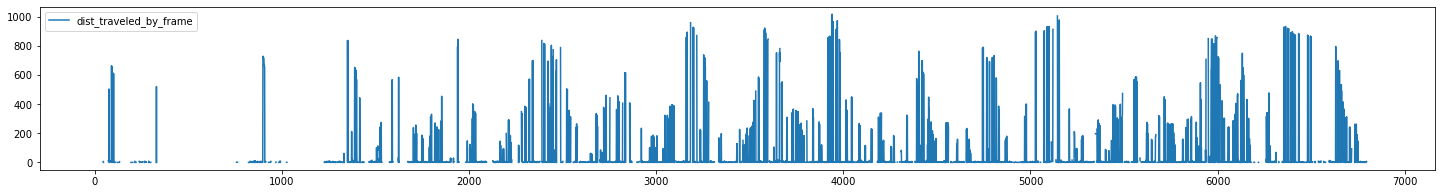

In [485]:
speed_data = get_velocity(sample_data, 'testsubject', 'nose')
velocity = clean_velocity(speed_data)

velocity.plot.line(y = 'dist_traveled_by_frame', figsize = (25, 3))

<AxesSubplot:>

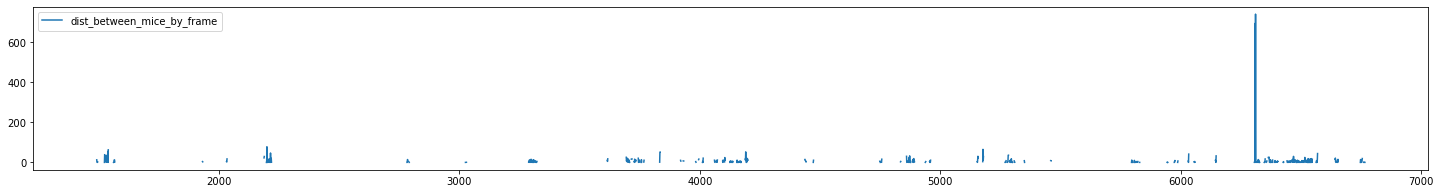

In [462]:
delta_dif_between_mice = get_velocity_between_mice(sample_data, 'testsubject', 'midpoint', 'intruder', 'midpoint')
velocity_between_mice = clean_velocity(delta_dif_between_mice)

velocity_between_mice.plot.line(y ='dist_between_mice_by_frame', figsize = (25, 3))

## Shenanigans below....

In [470]:
def find_cross_length(l, h):
    cross = np.sqrt((l**2)+(h**2))
    return cross

In [471]:
find_cross_length(1173, 800)

1419.8341452437323

In [476]:
##i am not sure if this is interesting or not....

def get_angle_between_mice(df, sub1, body_part1, sub2, body_part2):
    df['angle_between_mice'] = np.arctan2(df[sub1+'_'+body_part1+'_x']-df[sub2+'_'+body_part2+'_x'], df[sub1+'_'+body_part1+'_y']-df[sub2+'_'+body_part2+'_y'])
    return df

In [488]:
import sklearn

from scipy.ndimage import gaussian_filter

#sklearn.preprocessing.MinMaxScaler

In [490]:
gaussian_velocity = gaussian_filter(velocity, sigma=1)

<AxesSubplot:>

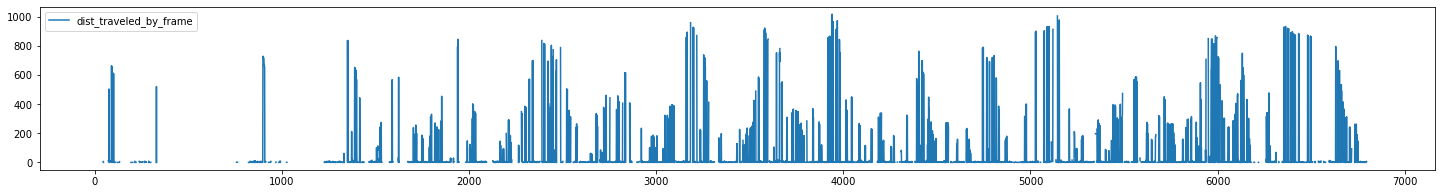

In [491]:
velocity.plot.line(y = 'dist_traveled_by_frame', figsize = (25, 3))

In [494]:
'plot gaussian_velocity here'
gaussian_velocity = pd.DataFrame(gaussian_velocity)

gaussian_velocity.plot.line(y ='dist_between_mice_by_frame', figsize = (25, 3))

KeyError: 'dist_between_mice_by_frame'